In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (
        pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return 1 - dice.mean()


In [3]:
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return img, mask


In [4]:
# ---------- CBAM 模块 ----------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

# ---------- REBNCONV ----------
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(out_ch)
        self.sa = SpatialAttention()

    def forward(self, x):
        out = self.conv(x)
        out = out * self.ca(out)
        out = out * self.sa(out)
        return out


class RSU7(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.stage1 = REBNCONV(out_ch, mid_ch)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage2 = REBNCONV(mid_ch, mid_ch)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage3 = REBNCONV(mid_ch, mid_ch)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage4 = REBNCONV(mid_ch, mid_ch)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage5 = REBNCONV(mid_ch, mid_ch)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage6 = REBNCONV(mid_ch, mid_ch)
        self.pool6 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage7 = REBNCONV(mid_ch, mid_ch)

        self.stage6d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage5d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage4d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage3d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage2d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage1d = REBNCONV(mid_ch * 2, out_ch)

    def forward(self, x):
        hxin = self.rebnconvin(x)
        hx1 = self.stage1(hxin)
        hx2 = self.stage2(self.pool1(hx1))
        hx3 = self.stage3(self.pool2(hx2))
        hx4 = self.stage4(self.pool3(hx3))
        hx5 = self.stage5(self.pool4(hx4))
        hx6 = self.stage6(self.pool5(hx5))
        hx7 = self.stage7(self.pool6(hx6))

        hx6d = self.stage6d(torch.cat((nn.functional.interpolate(hx7, size=hx6.shape[2:], mode='bilinear', align_corners=False), hx6), dim=1))
        hx5d = self.stage5d(torch.cat((nn.functional.interpolate(hx6d, size=hx5.shape[2:], mode='bilinear', align_corners=False), hx5), dim=1))
        hx4d = self.stage4d(torch.cat((nn.functional.interpolate(hx5d, size=hx4.shape[2:], mode='bilinear', align_corners=False), hx4), dim=1))
        hx3d = self.stage3d(torch.cat((nn.functional.interpolate(hx4d, size=hx3.shape[2:], mode='bilinear', align_corners=False), hx3), dim=1))
        hx2d = self.stage2d(torch.cat((nn.functional.interpolate(hx3d, size=hx2.shape[2:], mode='bilinear', align_corners=False), hx2), dim=1))
        hx1d = self.stage1d(torch.cat((nn.functional.interpolate(hx2d, size=hx1.shape[2:], mode='bilinear', align_corners=False), hx1), dim=1))
        return hx1d + hxin

class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.stage1 = RSU7(in_ch, 32, 64)
        self.outconv = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x = self.stage1(x)
        x = self.outconv(x)
        return torch.sigmoid(x)


In [5]:
transform_img = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = HairMaskDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    mask_dir="/root/autodl-fs/skin_hair_dataset/alignment/mask",
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = U2NET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(200):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = dice_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "hair_seg_u2net_dice.pth")
print("✅ 模型已保存：hair_seg_u2net_dice.pth")


Epoch 1: Loss = 0.9096
Epoch 2: Loss = 0.8813
Epoch 3: Loss = 0.8604
Epoch 4: Loss = 0.8425
Epoch 5: Loss = 0.8291
Epoch 6: Loss = 0.8150
Epoch 7: Loss = 0.7955
Epoch 8: Loss = 0.7708
Epoch 9: Loss = 0.7540
Epoch 10: Loss = 0.7366
Epoch 11: Loss = 0.7124
Epoch 12: Loss = 0.7214
Epoch 13: Loss = 0.6955
Epoch 14: Loss = 0.6832
Epoch 15: Loss = 0.6659
Epoch 16: Loss = 0.6524
Epoch 17: Loss = 0.6362
Epoch 18: Loss = 0.6276
Epoch 19: Loss = 0.6334
Epoch 20: Loss = 0.6017
Epoch 21: Loss = 0.5952
Epoch 22: Loss = 0.5836
Epoch 23: Loss = 0.5739
Epoch 24: Loss = 0.5605
Epoch 25: Loss = 0.5439
Epoch 26: Loss = 0.5476
Epoch 27: Loss = 0.5412
Epoch 28: Loss = 0.5310
Epoch 29: Loss = 0.5068
Epoch 30: Loss = 0.5088
Epoch 31: Loss = 0.5018
Epoch 32: Loss = 0.4924
Epoch 33: Loss = 0.4807
Epoch 34: Loss = 0.4700
Epoch 35: Loss = 0.4680
Epoch 36: Loss = 0.4585
Epoch 37: Loss = 0.4432
Epoch 38: Loss = 0.4373
Epoch 39: Loss = 0.4292
Epoch 40: Loss = 0.4225
Epoch 41: Loss = 0.4173
Epoch 42: Loss = 0.4127
E

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0000461.jpg


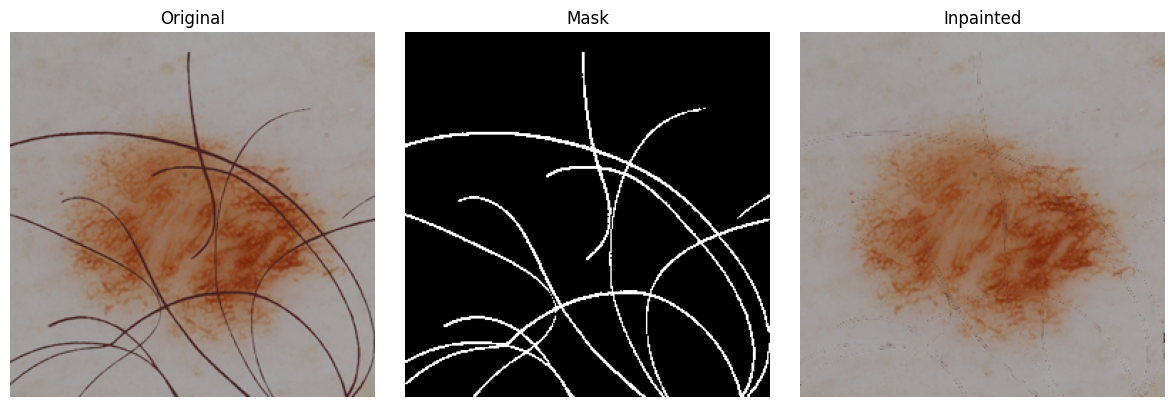

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


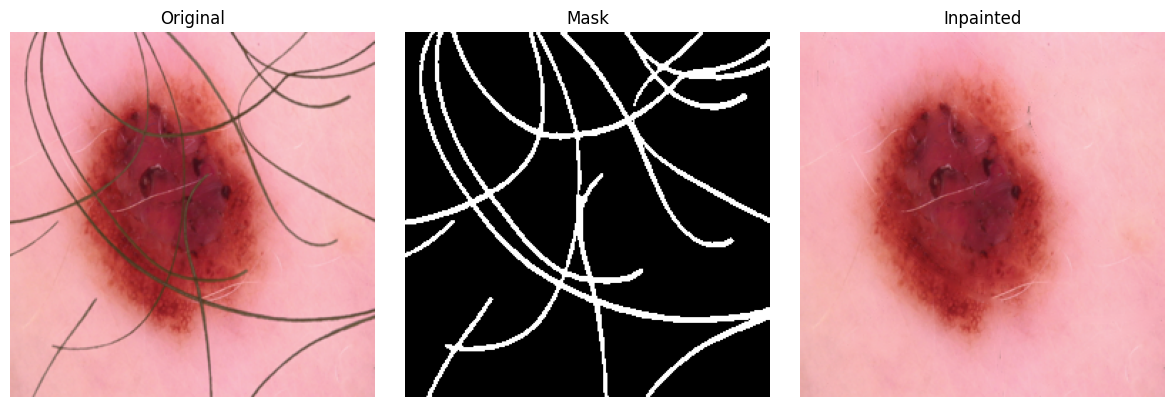

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


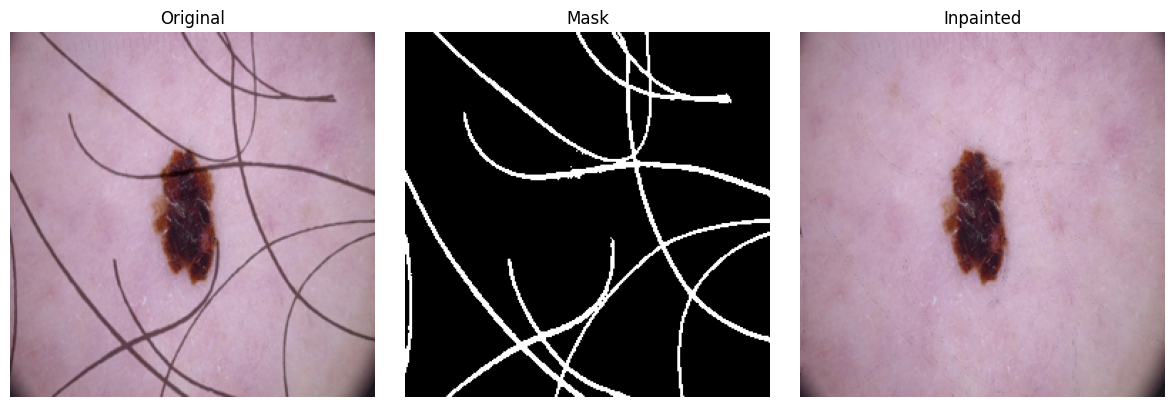

In [6]:
# ---------- 5. 毛发去除函数 ----------
def inpaint_image(image_path, save_path=None):
    model.eval()
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return image_cv, binary_mask, inpainted

# ---------- 6. 测试、可视化与保存 Inpainted 图像 ----------
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ---------- 7. 图像质量指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
original_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 没有毛发的 ground-truth 原图
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 累加指标
total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理修复图像
        img_path = os.path.join(image_dir, img_name)
        original, _, inpainted = inpaint_image(img_path)

        # 加载 ground-truth（无毛发）图像
        gt_path = os.path.join(original_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1
        print(f"✅ {img_name}  |  MSE: {mse:.4f}  PSNR: {psnr:.2f}  SSIM: {ssim:.4f}  UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败 {img_name}：{str(e)}")

# 平均指标打印
if valid_count > 0:
    print("\n📊 平均指标：")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np

# 推理函数应已定义，返回: 原图, 掩码, 修复图
# def inpaint_image(image_path): ...

input_dir = "/root/autodl-fs/processed/processed/train/mel"
output_dir = "/root/autodl-fs/generate/train/mel"

# 创建输出目录（若不存在）
os.makedirs(output_dir, exist_ok=True)

# 处理所有图像
image_list = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

for img_name in image_list:
    try:
        img_path = os.path.join(input_dir, img_name)
        _, _, inpainted = inpaint_image(img_path)

        # OpenCV 的 inpainted 是 BGR 格式，保存前转回 RGB（可选）
        if isinstance(inpainted, np.ndarray):
            save_img = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)
        else:
            raise ValueError("inpaint_image 输出格式异常")

        save_path = os.path.join(output_dir, img_name)
        Image.fromarray(save_img).save(save_path)
        print(f"✅ 已保存: {save_path}")
        
    except Exception as e:
        print(f"⚠️ 推理失败: {img_name}，错误信息: {str(e)}")

print(f"推理结束")